<a href="https://www.kaggle.com/code/ziadhamadafathy/sentiment-analysis-for-books-reviews?scriptVersionId=129196441" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Import Libraries

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from string import punctuation
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report

**Reading the training data**

In [2]:
df_train = pd.read_csv('/kaggle/input/goodreads-books-reviews-290312/goodreads_train.csv')
print('train set: {0}'.format(df_train.shape))
df_train.head()

train set: (900000, 11)


,user_id,book_id,review_id,rating,review_text,date_added,date_updated,read_at,started_at,n_votes,n_comments
0,8842281e1d1347389f2ab93d60773d4d,18245960,dfdbb7b0eb5a7e4c26d59a937e2e5feb,5,This is a special book. It started slow for ab...,Sun Jul 30 07:44:10 -0700 2017,Wed Aug 30 00:00:26 -0700 2017,Sat Aug 26 12:05:52 -0700 2017,Tue Aug 15 13:23:18 -0700 2017,28,1
1,8842281e1d1347389f2ab93d60773d4d,16981,a5d2c3628987712d0e05c4f90798eb67,3,Recommended by Don Katz. Avail for free in Dec...,Mon Dec 05 10:46:44 -0800 2016,Wed Mar 22 11:37:04 -0700 2017,NaN,NaN,1,0
2,8842281e1d1347389f2ab93d60773d4d,28684704,2ede853b14dc4583f96cf5d120af636f,3,"A fun, fast paced science fiction thriller. I ...",Tue Nov 15 11:29:22 -0800 2016,Mon Mar 20 23:40:27 -0700 2017,Sat Mar 18 23:22:42 -0700 2017,Fri Mar 17 23:45:40 -0700 2017,22,0
3,8842281e1d1347389f2ab93d60773d4d,27161156,ced5675e55cd9d38a524743f5c40996e,0,Recommended reading to understand what is goin...,Wed Nov 09 17:37:04 -0800 2016,Wed Nov 09 17:38:20 -0800 2016,NaN,NaN,5,1
4,8842281e1d1347389f2ab93d60773d4d,25884323,332732725863131279a8e345b63ac33e,4,"I really enjoyed this book, and there is a lot...",Mon Apr 25 09:31:23 -0700 2016,Mon Apr 25 09:31:23 -0700 2016,Sun Jun 26 00:00:00 -0700 2016,Sat May 28 00:00:00 -0700 2016,9,1


In [3]:
# Information about the data
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900000 entries, 0 to 899999
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       900000 non-null  object
 1   book_id       900000 non-null  int64 
 2   review_id     900000 non-null  object
 3   rating        900000 non-null  int64 
 4   review_text   900000 non-null  object
 5   date_added    900000 non-null  object
 6   date_updated  900000 non-null  object
 7   read_at       808234 non-null  object
 8   started_at    625703 non-null  object
 9   n_votes       900000 non-null  int64 
 10  n_comments    900000 non-null  int64 
dtypes: int64(4), object(7)
memory usage: 75.5+ MB


**Display the number of each rating**

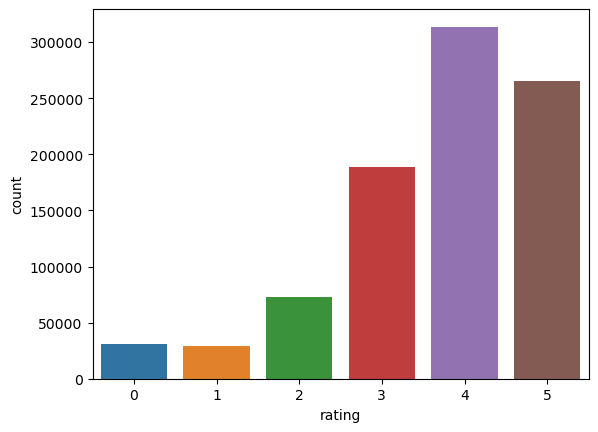

In [4]:
sns.countplot(x=df_train['rating']);

### Tetx preprocessing

In [5]:
# Modify the form of some words
replace_list = {r"'m": ' am',
                r"'re": ' are',
                r"let’s": 'let us',
                r"'s":  ' is',
                r"'ve": ' have',
                r"can't": 'can not',
                r"cannot": 'can not',
                r"shan’t": 'shall not',
                r"n't": ' not',
                r"'d": ' would',
                r"'ll": ' will',
                r"'scuse": 'excuse',
                ',': ' ,',
                '.': ' .',
                '!': ' !',
                '?': ' ?',
                '\s+': ' '}
def clean_text(text):
    text = text.lower()
    for s in replace_list:
        text = text.replace(s, replace_list[s])
    text = ' '.join(text.split())
    return text

In [6]:
# Apply the clean_text function
df_train['review_text'] = df_train['review_text'].apply(lambda p: clean_text(p))
y = df_train['rating']

In [7]:
nlp = spacy.load('en_core_web_sm')

# We will delete 'not' from stopwords because in sometimes it affects on meaning
nlp.Defaults.stop_words.remove('not')
nlp.vocab['not'].is_stop = False

In [8]:
stop_words = set(stopwords.words('english'))
punctuation = list(punctuation)

lemmatizer = WordNetLemmatizer()

**Cleaning our text data**

In [9]:
def remove_stop_words(document):
    # Remove all the special characters
    document = re.sub(r'\W', ' ', str(document))

    # remove all single characters
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)

    # Remove single characters from the start
    document = re.sub(r'\^[a-zA-Z]\s+', ' ', document) 

    # Remove single digit 
    document = re.sub(r'\s*\d\s+', '', document)

    # Tokenizer, Stemmer and removing stop_words
    document = word_tokenize(document)
        
    document = [lemmatizer.lemmatize(word, pos='v') for word in document if word not in stop_words and word not in punctuation]

    document = ' '.join(document)
        
    return document

In [10]:
# Apply the remove_stop_words function
df_train['review_text'] = df_train['review_text'].apply(lambda x: remove_stop_words(x))

In [11]:
# Example on our data cleaned
df_train['review_text'][818021]

'read marie lu short horror story girl without face slasher girls monster boys anxious read although first half young elites quite dull main character adelina amouteru fascinate read ya fantasy character fairly complex struggle side psyche good evil think novel groundbreaking well love lu incorporate diverse character decent world build unique plot latter half young elites insanely better first full action intrigue course interest input adelina anxious start rise society soon'

**Our data is not balancing and when we create ML model the percentage is not accurate, so we will use resample from sklearn to do balancing for our data**

In [12]:
from sklearn.utils import resample
#majority = max(df_train['rating'].value_counts())
majority = 1000000
df_0 = df_train[(df_train['rating']==0)] 
df_1 = df_train[(df_train['rating']==1)] 
df_2 = df_train[(df_train['rating']==2)] 
df_3 = df_train[(df_train['rating']==3)]
df_4 = df_train[(df_train['rating']==4)]
df_5 = df_train[(df_train['rating']==5)] 

df_0_upsampled = resample(df_0, replace=True, n_samples= majority, random_state=44) 
df_1_upsampled = resample(df_1, replace=True, n_samples= majority, random_state=44) 
df_2_upsampled = resample(df_2, replace=True, n_samples= majority, random_state=44) 
df_3_upsampled = resample(df_3, replace=True, n_samples= majority, random_state=44)
df_4_upsampled = resample(df_4, replace=True, n_samples= majority, random_state=44)
df_5_upsampled = resample(df_5, replace=True, n_samples= majority, random_state=44) 

df_upsampled = pd.concat([df_0_upsampled, df_1_upsampled, df_2_upsampled, df_4_upsampled, df_3_upsampled, df_5_upsampled])

In [13]:
df_upsampled.head()

,user_id,book_id,review_id,rating,review_text,date_added,date_updated,read_at,started_at,n_votes,n_comments
451339,7d11a9c676ed0cbf847e54821502b487,25567459,603f3967f09d8363f353ea79e32e4fc4,0,receive copy book publisher via netgalley exch...,Wed Nov 04 13:35:01 -0800 2015,Sat Apr 30 05:56:40 -0700 2016,NaN,NaN,0,0
111494,0bbf628a7b8d7a0899673d069e0f96e3,68428,63775d05adf3f6149a35265a42fcf55d,0,sequels look interest bookstore request librar...,Wed Nov 04 11:43:57 -0800 2009,Wed Nov 04 11:47:26 -0800 2009,Wed Nov 04 00:00:00 -0800 2009,NaN,0,0
810388,ba32d3184b231f407d4e6af78c1d079e,30816428,505733aca347181c7d474030caa2c75f,0,dnf 2am bore bore,Mon Jul 04 07:59:06 -0700 2016,Fri Mar 17 18:34:09 -0700 2017,Thu Dec 01 00:00:00 -0800 2016,Mon Nov 28 00:00:00 -0800 2016,5,1
764709,6c96156f7335ab2d3976df3ddc4c359c,20874388,e4b633f3603e9261b20b35c2b2a4d7b8,0,3just start skim get better 5and give book foc...,Fri Apr 01 20:36:47 -0700 2016,Sun Apr 24 06:22:05 -0700 2016,NaN,Wed Apr 20 00:00:00 -0700 2016,0,0
526748,874507ab349b2258eaecd967f4573c00,14165516,357ff56ec1da502b5064f87c1eeb24ee,0,dnf ing one could make past initial set book,Wed Sep 26 07:47:46 -0700 2012,Mon Oct 01 06:20:01 -0700 2012,Mon Oct 01 06:20:01 -0700 2012,Fri Sep 28 00:00:00 -0700 2012,0,0


In [14]:
# delete the not important variables
del [df_0_upsampled, df_1_upsampled, df_2_upsampled, df_4_upsampled, df_3_upsampled, df_5_upsampled]

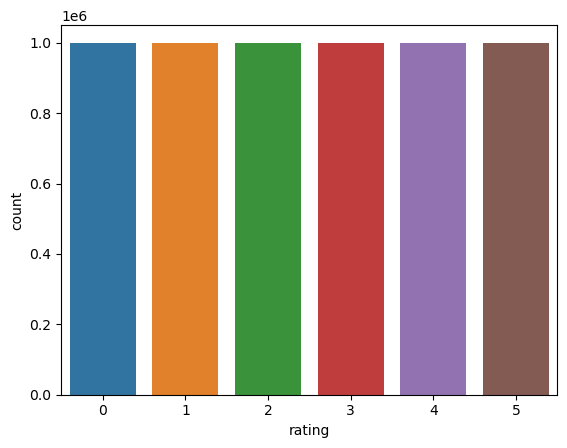

In [15]:
# Display the count of each type of rating after balancing
sns.countplot(x=df_upsampled['rating']);

#### Using TfidfVectorizer to convert our text data to matrix of TF-IDF features

In [16]:
tfidfconverter = TfidfVectorizer()
X_ = tfidfconverter.fit_transform(df_upsampled['review_text'])

##### Splitting our data to training and testing

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_, df_upsampled['rating'], test_size=0.01, random_state=1000)

In [18]:
X_test.shape, y_test.shape

((60000, 431596), (60000,))

## Machine Learning Models

**LogisticRegression model**

In [19]:
LogisticRegressionModel = LogisticRegression(C=1, penalty='l2', solver='sag', multi_class='multinomial', random_state=150, max_iter=500)
LogisticRegressionModel.fit(X_train, y_train)

#Calculating Details
print('LogisticRegressionModel Train Score is : ' , LogisticRegressionModel.score(X_train, y_train))
print('LogisticRegressionModel Test Score is : ' , LogisticRegressionModel.score(X_test, y_test))

LogisticRegressionModel Train Score is :  0.6920515151515152
LogisticRegressionModel Test Score is :  0.6789333333333334


In [20]:
scores = cross_val_score(LogisticRegressionModel, X_test, y_test, cv=5)
print('Cross-Validation Accuracy Scores', scores)

Cross-Validation Accuracy Scores [0.48508333 0.47366667 0.48633333 0.48325    0.489     ]


In [21]:
y_pred = LogisticRegressionModel.predict(X_test)

Confusion Matrix is : 
 [[8026  507  337  316  353  510]
 [ 502 8566  684  185   86   80]
 [ 559 1026 6715 1169  356  186]
 [ 557  465 1351 5508 1534  564]
 [ 576  177  453 1650 4987 1986]
 [ 574  140  215  480 1686 6934]]


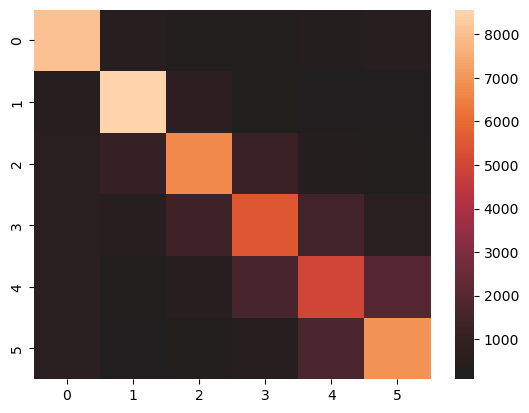

In [22]:
CM = confusion_matrix(y_test, y_pred)
print('Confusion Matrix is : \n', CM)

# drawing confusion matrix
sns.heatmap(CM, center = True)
plt.show()

In [23]:
ClassificationReport = classification_report(y_test,y_pred)
print(ClassificationReport)

              precision    recall  f1-score   support

           0       0.74      0.80      0.77     10049
           1       0.79      0.85      0.82     10103
           2       0.69      0.67      0.68     10011
           3       0.59      0.55      0.57      9979
           4       0.55      0.51      0.53      9829
           5       0.68      0.69      0.68     10029

    accuracy                           0.68     60000
   macro avg       0.67      0.68      0.68     60000
weighted avg       0.67      0.68      0.68     60000



**LinearSVC Model**

In [24]:
lsvc = LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,intercept_scaling=1, loss='squared_hinge', max_iter=800,
          multi_class='ovr', penalty='l2', random_state=150, tol=0.0001, verbose=0)
lsvc.fit(X_train, y_train)

#Calculating Details
print('LinearSVC Model Train Score is : ' , lsvc.score(X_train, y_train))
print('LinearSVC Model Test Score is : ' , lsvc.score(X_test, y_test))

LinearSVC Model Train Score is :  0.7388215488215488
LinearSVC Model Test Score is :  0.72465


In [25]:
scores = cross_val_score(lsvc, X_test, y_test, cv=5)
print('Cross-Validation Accuracy Scores', scores)

Cross-Validation Accuracy Scores [0.4645     0.46058333 0.46958333 0.46433333 0.4695    ]


In [26]:
y_pred_svc = lsvc.predict(X_test)

Confusion Matrix is : 
 [[8581  388  231  216  202  431]
 [ 484 8897  441  132   74   75]
 [ 530  906 7234  868  284  189]
 [ 573  456 1166 5991 1205  588]
 [ 535  220  469 1369 5253 1983]
 [ 514  154  221  416 1201 7523]]


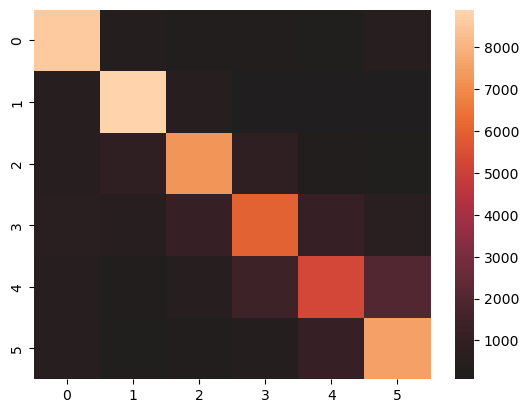

In [27]:
CM_SVC = confusion_matrix(y_test, y_pred_svc)
print('Confusion Matrix is : \n', CM_SVC)

# drawing confusion matrix
sns.heatmap(CM_SVC, center = True)
plt.show()

In [28]:
ClassificationReport = classification_report(y_test,y_pred_svc)
print(ClassificationReport)

              precision    recall  f1-score   support

           0       0.76      0.85      0.81     10049
           1       0.81      0.88      0.84     10103
           2       0.74      0.72      0.73     10011
           3       0.67      0.60      0.63      9979
           4       0.64      0.53      0.58      9829
           5       0.70      0.75      0.72     10029

    accuracy                           0.72     60000
   macro avg       0.72      0.72      0.72     60000
weighted avg       0.72      0.72      0.72     60000



**MultinomialNB model**

In [29]:
MultinomialNBModel = MultinomialNB(alpha=0.0001)
MultinomialNBModel.fit(X_train, y_train)

#Calculating Details
print('MultinomialNBModel Train Score is : ' , MultinomialNBModel.score(X_train, y_train))
print('MultinomialNBModel Test Score is : ' , MultinomialNBModel.score(X_test, y_test))

MultinomialNBModel Train Score is :  0.6600989898989899
MultinomialNBModel Test Score is :  0.6514833333333333


In [30]:
scores = cross_val_score(MultinomialNBModel, X_test, y_test, cv=3)
print('Cross-Validation Accuracy Scores', scores)

Cross-Validation Accuracy Scores [0.403   0.40525 0.40655]


In [31]:
y_pred_mnb = MultinomialNBModel.predict(X_test)

Confusion Matrix is : 
 [[6752  868  506  496  554  873]
 [ 611 7861 1020  348  120  143]
 [ 492 1213 6503 1151  381  271]
 [ 461  480 1304 5795 1331  608]
 [ 482  236  446 1647 5266 1752]
 [ 535  225  223  561 1573 6912]]


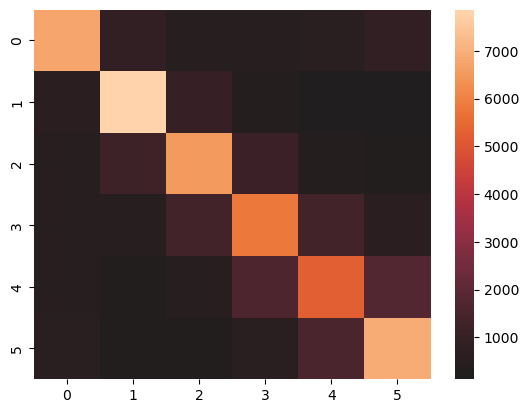

In [32]:
CM_MNB = confusion_matrix(y_test, y_pred_mnb)
print('Confusion Matrix is : \n', CM_MNB)

# drawing confusion matrix
sns.heatmap(CM_MNB, center = True)
plt.show()

In [33]:
ClassificationReport_MNB = classification_report(y_test,y_pred_mnb)
print(ClassificationReport_MNB)

              precision    recall  f1-score   support

           0       0.72      0.67      0.70     10049
           1       0.72      0.78      0.75     10103
           2       0.65      0.65      0.65     10011
           3       0.58      0.58      0.58      9979
           4       0.57      0.54      0.55      9829
           5       0.65      0.69      0.67     10029

    accuracy                           0.65     60000
   macro avg       0.65      0.65      0.65     60000
weighted avg       0.65      0.65      0.65     60000



# Sentiment Analysis with vader

In [34]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sentiments = SentimentIntensityAnalyzer()

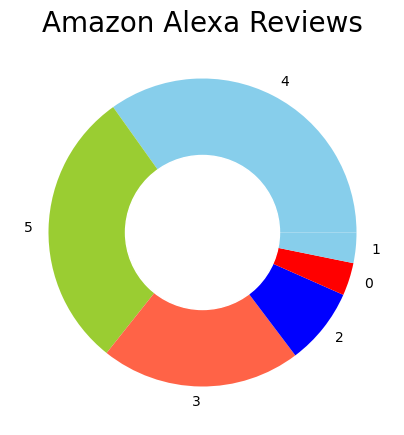

In [35]:
ratings = df_train["rating"].value_counts()
numbers = ratings.index
quantity = ratings.values

custom_colors = ["skyblue", "yellowgreen", 'tomato', "blue", "red"]
plt.figure(figsize=(5, 5))
plt.pie(quantity, labels=numbers, colors=custom_colors)
central_circle = plt.Circle((0, 0), 0.5, color='white')
fig = plt.gcf()
fig.gca().add_artist(central_circle)
plt.rc('font', size=12)
plt.title("Amazon Alexa Reviews", fontsize=20)
plt.show()

In [36]:
sentiments = SentimentIntensityAnalyzer()
df_train["Positive"] = [sentiments.polarity_scores(i)["pos"] for i in df_train["review_text"]]
df_train["Negative"] = [sentiments.polarity_scores(i)["neg"] for i in df_train["review_text"]]
df_train["Neutral"] = [sentiments.polarity_scores(i)["neu"] for i in df_train["review_text"]]
df_train.head()

,user_id,book_id,review_id,rating,review_text,date_added,date_updated,read_at,started_at,n_votes,n_comments,Positive,Negative,Neutral
0,8842281e1d1347389f2ab93d60773d4d,18245960,dfdbb7b0eb5a7e4c26d59a937e2e5feb,5,special book start slow first third middle thi...,Sun Jul 30 07:44:10 -0700 2017,Wed Aug 30 00:00:26 -0700 2017,Sat Aug 26 12:05:52 -0700 2017,Tue Aug 15 13:23:18 -0700 2017,28,1,0.224,0.109,0.668
1,8842281e1d1347389f2ab93d60773d4d,16981,a5d2c3628987712d0e05c4f90798eb67,3,recommend katz avail free december http www au...,Mon Dec 05 10:46:44 -0800 2016,Wed Mar 22 11:37:04 -0700 2017,NaN,NaN,1,0,0.392,0.000,0.608
2,8842281e1d1347389f2ab93d60773d4d,28684704,2ede853b14dc4583f96cf5d120af636f,3,fun fast pace science fiction thriller read in...,Tue Nov 15 11:29:22 -0800 2016,Mon Mar 20 23:40:27 -0700 2017,Sat Mar 18 23:22:42 -0700 2017,Fri Mar 17 23:45:40 -0700 2017,22,0,0.232,0.151,0.617
3,8842281e1d1347389f2ab93d60773d4d,27161156,ced5675e55cd9d38a524743f5c40996e,0,recommend read understand go middle america po...,Wed Nov 09 17:37:04 -0800 2016,Wed Nov 09 17:38:20 -0800 2016,NaN,NaN,5,1,0.293,0.000,0.707
4,8842281e1d1347389f2ab93d60773d4d,25884323,332732725863131279a8e345b63ac33e,4,really enjoy book lot recommend drag little en...,Mon Apr 25 09:31:23 -0700 2016,Mon Apr 25 09:31:23 -0700 2016,Sun Jun 26 00:00:00 -0700 2016,Sat May 28 00:00:00 -0700 2016,9,1,0.227,0.093,0.680


In [37]:
x = sum(df_train["Positive"])
y = sum(df_train["Negative"])
z = sum(df_train["Neutral"])

def sentiment_score(a, b, c):
    if (a>b) and (a>c):
        print("Positive 😊 ")
    elif (b>a) and (b>c):
        print("Negative 😠 ")
    else:
        print("Neutral 🙂 ")
sentiment_score(x, y, z)

Neutral 🙂 


In [38]:
print("Positive: ", x)
print("Negative: ", y)
print("Neutral: ", z)

Positive:  274577.0290000104
Negative:  99968.85499999509
Neutral:  525297.5229999389
